In [51]:
import matplotlib.pyplot as plt
import pandas as pd
import os


import classical_tsm

## Data

M5 Forecasting - Accuracy

In [32]:
data_root = "../data/M5-forecasting-accuracy" # Root dir of the M5 dataset

calendar = pd.read_csv(os.path.join(data_root, "calendar.csv"))
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [13]:
test = pd.read_csv(os.path.join(data_root, "sales_train_evaluation.csv"))
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [55]:
train = pd.read_csv(os.path.join(data_root, "sales_train_validation.csv"))
train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


d_331     13
d_697     11
d_1062    20
d_1427    20
d_1792    14
dtype: int64

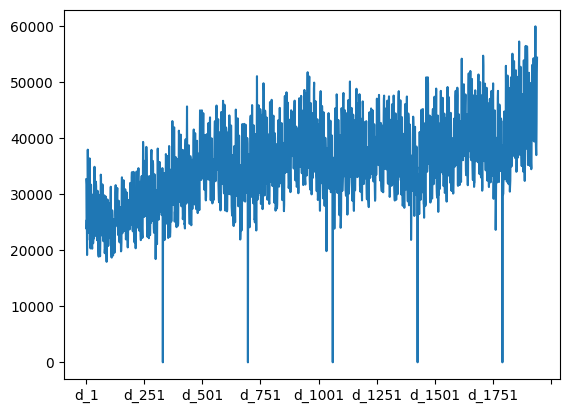

In [40]:
# Ventas totales por día
start_pos = train.columns.get_loc('d_1')

total_sales = train.iloc[:, start_pos:].sum()
total_sales.plot()
total_sales[total_sales < 1000]

In [35]:
calendar[calendar['d'] == "d_697"]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
696,2012-12-25,11248,Tuesday,4,12,2012,d_697,Christmas,National,NaN,NaN,0,0,0


<Axes: >

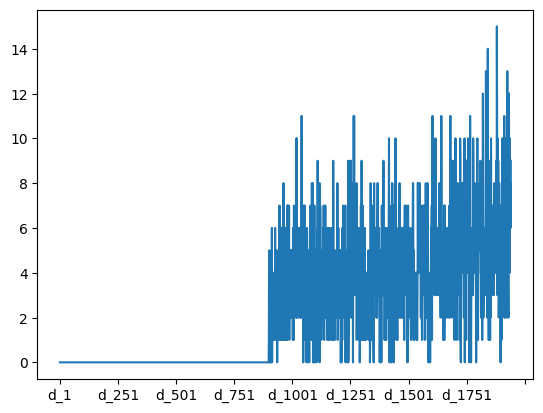

In [46]:
train[train['item_id'] == "HOBBIES_1_001"].iloc[:, start_pos:].sum().plot()

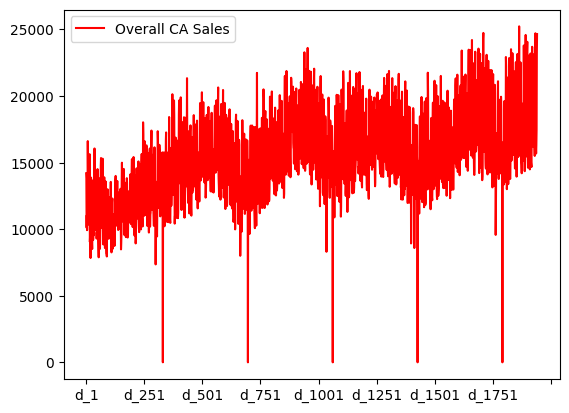

In [54]:
train[train['state_id'] == "CA"].iloc[:, start_pos:].sum().plot(color="red", label = "Overall CA Sales")
#sales[sales['state_id'] == "TX"].iloc[:, start_pos:].sum().plot(color="blue", label = "Overall TX Sales")
#sales[sales['state_id'] == "WI"].iloc[:, start_pos:].sum().plot(color="green", label = "Overall WI Sales")
plt.legend()